<font size="10">Discovering Conjugate Mappings: Conjugacy Between the Gissinger Poincare Map and the Logistic map</font>

<font size="4">This notebook employs an autoencoder neural network structure to discover a conjugacy between the Poincare map of the Rossler system and a cubic map. The 2-dimensional Poincare mapping (observed in collected data) is nearly 1-dimensional, as measured by the Lyapunov exponents and Kaplan-Yorke dimension. We employ an autoencoder neural network architecture to reduce the data to a 1-dimensional manifold and learn a cubic map representation of it.  </font>

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.5 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [1]:
import tensorflow as tf
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# Gissinger right-hand-side (scaled)
def Gissinger(x,t):
	# System parameters
	mu = 0.12 # bifurcation parameter
	nu = 0.1
	gamma = 0.85 
	
	# Equilibria for scaling
	xstar = np.sqrt(nu + gamma*np.sqrt(nu/mu))
	ystar = np.sqrt(mu + gamma*np.sqrt(mu/nu))
	zstar = -np.sqrt(nu*mu) - gamma
	
	# Rescaled variables
    x1hat = x[0]*xstar
	x2hat = x[1]*ystar
	x3hat = x[2]*zstar
	
	dxdt = [(mu*x1hat - x2hat*(x3hat + gamma))/xstar, (-nu*x2hat + x1hat*(x3hat + gamma))/ystar, (-x3hat + x1hat*x2hat)/zstar]
	
	return dxdt 

In [3]:
# Continuous-time simulation data

# Initializations
dt = .005
t_span = np.arange(0, 30000, dt)
x0 = [-1.5, 1.5, 1.3] 

# Solution data
xsol = []
xsol = odeint(Gissinger, x0, t_span)

Text(0, 0.5, '$x_2(t)$')

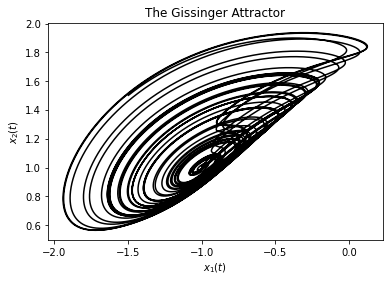

In [4]:
# Plot Gissinger Solution (x_2 vs. x_1)

plt.plot(xsol[1:100000,0],xsol[1:100000,1],'k')
plt.title("The Gissinger Attractor")
plt.xlabel("$x_1(t)$")
plt.ylabel("$x_2(t)$")

In [5]:
# Create section data

Psec = []
temp = [0]*len(xsol[:,1])
count = 0
for m in range(len(temp)-1):
    if (xsol[m,0] + xsol[m,1]) <= 0 and (xsol[m+1,0] + xsol[m+1,1]) >= 0: # section condition
        temp[count] = xsol[m+1,1:] 
        count = count + 1
Psec.append(np.array(temp[1:count]))   

xn, xnp1 = Psec[0][:-1], Psec[0][1:]

#Scale data into [0,1]
max_xn = xn.max()
min_xn = xn.min()

slope = 1/(max_xn - min_xn)
yint = -slope*min_xn

xn = slope*xn + yint
xnp1 = slope*xnp1 + yint

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

xnp1 = xnp1[:-forward_iters] 
for j in range(forward_iters): 
    xnforward.append(xn[j:-forward_iters+j])  

Text(0, 0.5, '$x_{2,n+1}$')

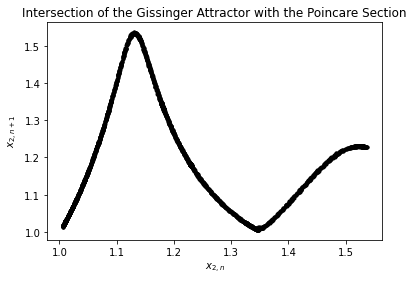

In [6]:
# Plot Rossler Section Data

plt.plot(Psec[0][:-1,0],Psec[0][1:,0],'k.')
plt.title("Intersection of the Gissinger Attractor with the Poincare Section")
plt.xlabel("$x_{2,n}$")
plt.ylabel("$x_{2,n+1}$")

In [7]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 1,
                 size_y = 1,
                 activation = 'selu',
                 steps = 1,
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.steps = steps
    self.numblksIn = numblksIn
    self.numblksOut = numblksOut
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Trainable network parameter
    self.c1 = tf.Variable(8.534422, trainable = True)
    self.c2 = tf.Variable( -18.299885, trainable = True) 
    self.c3 = tf.Variable(9.817207, trainable = True) 
    
    # Encoder function
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.encoder.add(layers.Dense(size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblksOut): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    self.decoder.add(tf.keras.layers.Dense(size_y, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x[0])
    encoded_p1 = self.c1*encoded + self.c2*tf.square(encoded) + self.c3*tf.math.multiply(tf.square(encoded),encoded)
    decoded = self.decoder(encoded_p1)
    
    # Conjugacy loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x[0] - x_recon)))
    
    # Build loss function
    yn = encoded
    for s in range(self.steps):
        ynp1 = self.encoder(x[s+1])
        
        # Iteration loss in y
        y_step = self.c1*yn + self.c2*tf.square(yn) + self.c3*tf.math.multiply(tf.square(yn),yn)
        self.add_loss((tf.reduce_mean(tf.math.square(ynp1 - y_step)))/self.steps)

        # Iteration loss in x
        xnp1 = self.decoder(y_step)
        self.add_loss((tf.reduce_mean(tf.math.square(x[s+1] - xnp1)))/self.steps)
 
        yn = y_step
    
    return decoded

In [8]:
# Neural Network Parameters

width = 100 # width of each NN layer
size_x = 2 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = 'selu' # nonlinear activation function at each NN layer
steps = 1 # Number of steps for loss function
learning_rate = 0.00001
numblks_in = 3 # number of layers for the encoder NN
numblks_out = 3 # number of layers for the decoder NN

In [9]:
conjugacy = Conjugacy(width, size_x, size_y, activation, steps, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 100)

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xnforward, xnp1, callbacks = [callback], epochs = 100)

Epoch 1/100
82/82 [==============================] - 2s 2ms/step - loss: 0.6114
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 0.4166
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 0.3523
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 0.2969
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 0.2540
Epoch 6/100
82/82 [==============================] - 0s 2ms/step - loss: 0.2249
Epoch 7/100
82/82 [==============================] - 0s 2ms/step - loss: 0.2062
Epoch 8/100
82/82 [==============================] - 0s 2ms/step - loss: 0.1916
Epoch 9/100
82/82 [==============================] - 0s 2ms/step - loss: 0.1810
Epoch 10/100
82/82 [==============================] - 0s 2ms/step - loss: 0.1743
Epoch 11/100
82/82 [==============================] - 0s 2ms/step - loss: 0.1705
Epoch 12/100
82/82 [==============================] - 0s 2ms/step - loss: 0.1666
Epoch 13/100
82/82 [=================

In [10]:
# Print Discovered Mapping

print('Discovered Conjugate Mapping:')
print('')
print('g(y) =',conjugacy.c1.numpy(),'*y +',conjugacy.c2.numpy(),'*y^2 +',conjugacy.c3.numpy(),'*y^3')

# Network Summary
print('')
conjugacy.summary()

Discovered Conjugate Mapping:

g(y) = 8.543814 *y + -18.30015 *y^2 + 9.816955 *y^3

Model: "conjugacy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1)                 20601     
                                                                 
 sequential_1 (Sequential)   (None, 1)                 20501     
                                                                 
Total params: 41,105
Trainable params: 41,105
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Save Results
#!mkdir -p saved_conjugacy_networks
#conjugacy.save('saved_conjugacy_networks/gissinger')

In [12]:
## Load and view summary of the Gissinger conjugacy
## Gissinger system is scaled so that the Poincare section is x_1 = - x_2

gissinger = tf.keras.models.load_model('saved_conjugacy_networks/gissinger')

# Print specs
print('Discovered Conjugate Mapping:')
print('g(y) = ',gissinger.c1.numpy(),'*y +',gissinger.c2.numpy(),'*y^2 +',gissinger.c3.numpy(),'*y^3')
print('')

# Network summary
gissinger.summary()

Discovered Conjugate Mapping:
g(y) =  8.534422 *y + -18.299885 *y^2 + 9.817207 *y^3

Model: "conjugacy_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 1)                 10501     
                                                                 
 sequential_13 (Sequential)  (None, 2)                 10502     
                                                                 
Total params: 21,007
Trainable params: 21,006
Non-trainable params: 1
_________________________________________________________________


In [13]:
## UPOs for the Gissinger system 
# --> These values are used in Gissinger_UPO.m to initiate the 
#      shooting method that identifies the continuous time unstable 
#       periodic orbits in the chaotic flow 

# Parameters used to rescale training data into [0,1]
slope = 1.33792817990096
yint = -1.3421155560726923

print('Summary of (x_2,x_3)-values of the UPOs in the (scaled) Gissinger system')
print('Poincare section: x_1 = -x_2')
print('')

# Fixed Point
ystar = tf.convert_to_tensor([0.61389438295257985102672004747599], dtype=tf.float32)
xstar = gissinger.decoder(ystar)
xstar = (xstar - yint)/slope
print('Fixed point: ',xstar.numpy())
print('')

# Period 2 orbit - 01 orbit
ystar2 = tf.convert_to_tensor([[0.12685436053808123553182613198832], [0.80818666596200491237901592571151]], dtype=tf.float32)
xstar2 = gissinger.decoder(ystar2)
xstar2 = (xstar2 - yint)/slope
print('Period 2: ',np.transpose(xstar2.numpy()))
print('')

# Period 2 orbit - 12 orbit
ystar22 = tf.convert_to_tensor([[0.39566533106051493720837650083326], [1.1200043324238354127092446557793]], dtype=tf.float32)
xstar22 = gissinger.decoder(ystar22)
xstar22 = (xstar22 - yint)/slope
print('Period 2: ',np.transpose(xstar22.numpy()))
print('')

# Period 2 orbit - 02 orbit
ystar22 = tf.convert_to_tensor([[0.20726239382087857941166148457872], [1.0701514224824713257066795171263]], dtype=tf.float32)
xstar22 = gissinger.decoder(ystar22)
xstar22 = (xstar22 - yint)/slope
print('Period 2: ',np.transpose(xstar22.numpy()))
print('')

# Period 3 orbit - 001 orbit
ystar3 = tf.convert_to_tensor([[0.018048194427047163834778242768381], [0.14812766711481224415265888483505], [0.89455927213960191586979941312225]], dtype=tf.float32)
xstar3 = gissinger.decoder(ystar3)
xstar3 = (xstar3 - yint)/slope
print('Period 3: ',xstar3.numpy())
print('')

# Period 3 orbit - 002 orbit
ystar3 = tf.convert_to_tensor([[0.020882720664710181113000289958868], [0.17033099240343838426605949546189], [0.97126267736032357928784750276975]], dtype=tf.float32)
xstar3 = gissinger.decoder(ystar3)
xstar3 = (xstar3 - yint)/slope
print('Period 3: ',xstar3.numpy())
print('')

# Period 3 orbit - 012 orbit
ystar3 = tf.convert_to_tensor([[0.061985759791847736123352992091226], [0.46103828759788111851514852612029], [1.0069922568065487024600610428776]], dtype=tf.float32)
xstar3 = gissinger.decoder(ystar3)
xstar3 = (xstar3 - yint)/slope
print('Period 3: ',xstar3.numpy())
print('')

# Period 3 orbit - 011 orbit
ystar3 = tf.convert_to_tensor([[0.073240633408982551459393615114142], [0.52524136794522582667226871262789], [0.83647527385845066032934913488574]], dtype=tf.float32)
xstar3 = gissinger.decoder(ystar3)
xstar3 = (xstar3 - yint)/slope
print('Period 3: ',xstar3.numpy())
print('')

# Period 3 orbit - 121 orbit
ystar3 = tf.convert_to_tensor([[0.31440822558676721211651220013901], [1.1794217814319002733352180684236], [0.72313645400346077177352955796334]], dtype=tf.float32)
xstar3 = gissinger.decoder(ystar3)
xstar3 = (xstar3 - yint)/slope
print('Period 3: ',xstar3.numpy())
print('')

# Period 4 orbit - 1112 orbit
ystar4 = tf.convert_to_tensor([[1.150301823701711084029285934043], [0.57450565198675484055184654835118], [0.70514444839200450880458985444718], [0.3456817155319883721802368412466]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0012 orbit
ystar4 = tf.convert_to_tensor([[0.0079095276407994573085195594928224], [0.066363252218034823810791149592307], [0.48864708619674827754850848428566], [0.94619163325572243629722497984895]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0011 orbit
ystar4 = tf.convert_to_tensor([[0.0081590057085012448866131665642232], [0.068419518042131517817174999912445], [0.50139939012385647871199254392868], [0.91602153723181135880302542121795]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0111 orbit
ystar4 = tf.convert_to_tensor([[0.092632962769055326058199353708841], [0.64134335155401777831331406846446], [0.5361237361916815223185109884331], [0.82840013671543150217025558044137]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0112 orbit
ystar4 = tf.convert_to_tensor([[0.098367513455691284222106872619193], [0.67178133414025437774360921382528], [0.45097337069384123067500087594695], [1.0274323819676653510561390721576]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0102 orbit
ystar4 = tf.convert_to_tensor([[0.11934589327392768851161371426281], [0.77458309637044152414792747096673], [0.1934584712712085848989524915641], [1.0372420606972765822643009655124]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0212 orbit
ystar4 = tf.convert_to_tensor([[0.23727985087551712193559057415425], [1.1258819136499991927253023522861], [0.42254690653634138947143815730107], [1.0794738834785467735390241683697]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 0211 orbit
ystar4 = tf.convert_to_tensor([[0.25983831123868575724300687065023], [1.1542612354862339500826803203028], [0.56700260007112612005159205618063], [0.74532073962601695501766095499849]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit - 1211 orbit
ystar4 = tf.convert_to_tensor([[0.36221055422443496714779905856116], [1.1568981806833176203519955074041], [0.58168810533091943051395452032973], [0.7046319894192977684426747817238]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

# Period 4 orbit -  orbit
ystar4 = tf.convert_to_tensor([[1.150301823701711084029285934043], [0.57450565198675484055184654835118], [0.70514444839200450880458985444718], [0.3456817155319883721802368412466]], dtype=tf.float32)
xstar4 = gissinger.decoder(ystar4)
xstar4 = (xstar4 - yint)/slope
print('Period 4: ',xstar4.numpy())
print('')

Summary of (x_2,x_3)-values of the UPOs in the (scaled) Gissinger system
Poincare section: x_1 = -x_2

Fixed point:  [[1.2179209 1.3286662]]

Period 2:  [[1.073515  1.2816105]
 [1.12011   1.4147233]]

Period 2:  [[1.1573765 1.4683257]
 [1.2425616 1.6616613]]

Period 2:  [[1.1006762 1.4226933]
 [1.160484  1.6029335]]

Period 3:  [[1.0262649 1.0436301]
 [1.0813795 1.1323658]
 [1.3190414 1.4656686]]

Period 3:  [[1.0275182 1.0456374]
 [1.0889106 1.1433766]
 [1.3570137 1.5177892]]

Period 3:  [[1.0456371 1.0748404]
 [1.176175  1.269483 ]
 [1.3761501 1.543645 ]]

Period 3:  [[1.0505573 1.0827899]
 [1.1940813 1.2949812]
 [1.2935671 1.4306426]]

Period 3:  [[1.1335431 1.2081861]
 [1.5206745 1.7292262]
 [1.2482151 1.3697859]]

Period 4:  [[1.4952934 1.6964461]
 [1.2074699 1.3139266]
 [1.2420436 1.3622724]
 [1.1428388 1.2215891]]

Period 4:  [[1.0217707 1.0364347]
 [1.0475534 1.0779362]
 [1.183928  1.2805532]
 [1.3434799 1.4995136]]

Period 4:  [[1.0218817 1.036612 ]
 [1.0484523 1.0793886]
 [1.